In [72]:
steerings = []
center = []
left = []
right = []
speed = []
with open("../data/driving_log.csv") as f:
    lines = f.read().split("\n")
    print(len(lines))
    for i in range(len(lines)-2):
        line = lines[i+1]
        items = line.split(", ")
        steerings.append(float(items[3]))
        center.append(items[0])
        left.append(items[1])
        right.append(items[2])
        speed.append(items[-1])

8038


8036 8036 8036 8036


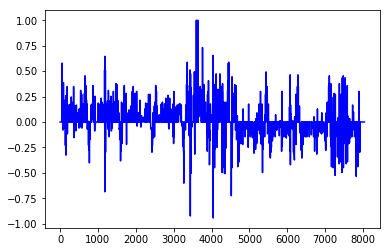

In [73]:
print(len(left),len(right),len(center),len(steerings))
time = range(8036)
plt.plot(time,steerings,  color="blue", linewidth=1.5, linestyle="-")
plt.show()

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.model_selection import train_test_split
import json
import h5py

In [75]:
def camera_adjust(steering, right, speed):
    reaction_time = 2.0
    shift = 20.0 
    # mile/hour to feet/sec
    speed  = speed/3600.0*5280
    adjacent = speed*reaction_time*12.0 
    angle_adj = np.arctan(float(shift)/adjacent)
    if not right:
        angle_adj = - angle_adj
    steering = steering+angle_adj
    return steering

In [76]:
def read_img(img_file, flip):
    img = cv2.imread(img_file)
    img_crop = img[60:150,:,:]
    if flip:
        img_crop = cv2.flip(img_crop, 1)
    return img_crop

In [77]:
a = read_img("../data/"+left[5], True)

In [78]:
def augment(img,steering):
    rows,cols,channles = img.shape
    x_range = 25
    dx = random.choice(range(-x_range,x_range))
    y_range = 8
    dy = random.choice(range(-y_range, y_range))
    d_angle = 0.0033*dx
    new_steering = steering+d_angle
    M = np.float32([[1,0,dx],[0,1,dy]])
    new_img = cv2.warpAffine(img, M, (cols,rows))
#     plt.imshow(new_img)
#     plt.show()
    return new_img, new_steering

In [79]:
img = read_img("../data/"+center[5],False)
print(steerings[5])
a = augment(img,0.1)

0.0


In [80]:
def generate_dataset(center,left,right,steerings):
    dataset = []
    for i in range(len(center)):
        data = (center[i],False,steerings[i])
        dataset.append(data)
    for i in range(len(left)):
        steer = steerings[i]+0.10
        data = (left[i], False, steer)
        dataset.append(data)
    for i in range(len(right)):
        steer = steerings[i]-0.10
        data = (right[i], False, steer)
        dataset.append(data)
    return dataset

In [81]:
dataset = generate_dataset(center, left, right, steerings)
print(len(dataset))

24108


In [82]:
def add_flip(dataset):
    new_data = []
    for item in dataset:
        new_data.append((item[0], True, -item[2]))
    dataset.extend(new_data)
    return dataset

In [83]:
dataset = add_flip(dataset)

In [84]:
print(len(dataset))

48216


In [85]:
# adjust brightness
def adjust_gamma(image, gamma=1.0):
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	return cv2.LUT(image, table)

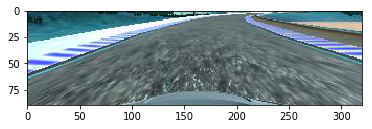

In [86]:
img = read_img("../data/"+dataset[30020][0], dataset[30020][1])
plt.imshow(img)
plt.show()

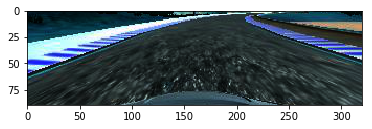

In [87]:
img = adjust_gamma(img, 0.5)
plt.imshow(img)
plt.show()

In [88]:
angles = [x[2] for x in dataset]

In [89]:
img,steer = augment(img, dataset[30020][2])

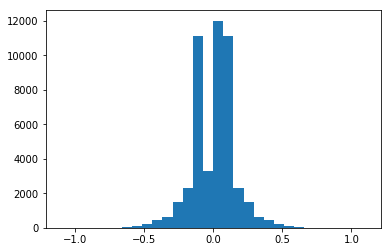

(array([  5.00000000e+00,   3.00000000e+00,   7.00000000e+00,
         8.00000000e+00,   7.00000000e+00,   1.70000000e+01,
         4.10000000e+01,   8.30000000e+01,   2.43000000e+02,
         4.47000000e+02,   6.15000000e+02,   1.51900000e+03,
         2.33300000e+03,   1.11300000e+04,   3.28900000e+03,
         1.20110000e+04,   1.11300000e+04,   2.33300000e+03,
         1.51900000e+03,   6.15000000e+02,   4.47000000e+02,
         2.43000000e+02,   8.30000000e+01,   4.10000000e+01,
         1.70000000e+01,   7.00000000e+00,   8.00000000e+00,
         7.00000000e+00,   3.00000000e+00,   5.00000000e+00]), array([-1.1       , -1.02666667, -0.95333333, -0.88      , -0.80666667,
       -0.73333333, -0.66      , -0.58666667, -0.51333333, -0.44      ,
       -0.36666667, -0.29333333, -0.22      , -0.14666667, -0.07333333,
        0.        ,  0.07333333,  0.14666667,  0.22      ,  0.29333333,
        0.36666667,  0.44      ,  0.51333333,  0.58666667,  0.66      ,
        0.73333333,  0.8066

In [90]:
a = plt.hist(angles, 30)
plt.show()
print(a)

In [91]:
def filter(dataset, threshold):
    delete_list = []
    for i in range(len(dataset)):
        if dataset[i][2] < threshold:
            if random.random() < 0.5:
                delete_list.append(i)
    for j in reversed(delete_list):
        del dataset[j]
    return dataset

In [92]:
# dataset = filter(dataset, 0.06)
# print(len(dataset))

In [93]:
def train_generator(train_dataset, batch_size):
    length = len(train_dataset)
    random.shuffle(train_dataset)
    train_pointer = 0
    while True:
        y_batch = []
        x_batch = []
        while(len(y_batch)<256):
            data = train_dataset[train_pointer%length]
            file = data[0]
            file_path = "../data/"+file
            angle = data[2]
            img = read_img(file_path, data[1])
            if angle < 0.07:
                if random.random()<0.5:
                    continue
            if random.random()<0.3:
                img, angle = augment(img, angle)
            img = cv2.resize(img, (200, 66))
            img = img/255.0
            x_batch.append(img)
            y_batch.append(angle)
            train_pointer+=1
        x_batch_out = np.array(x_batch)
        y_batch_out = np.array(y_batch)
        yield x_batch_out, y_batch_out

In [94]:
def valid_generator(valid_dataset, batch_size):
    length = len(valid_dataset)
    random.shuffle(valid_dataset)
    valid_pointer = 0
    while True:
        y_batch = []
        x_batch = []
        while(len(y_batch) < batch_size):
#             if valid_pointer > length:
            data = valid_dataset[valid_pointer%length]
            file = data[0]
            file_path = "../data/"+file
            angle = data[2]
            img = read_img(file_path, data[1])
    #         if angle < 0.07:
    #             if random.random()<0.5:
    #                 continue
    #         if random.random()<0.3:
    #             img, angle = augment(img, angle)
            img = cv2.resize(img, (200, 66))
            img = img/255.0
            x_batch.append(img)
            y_batch.append(angle)
            valid_pointer+=1
        x_batch_out = np.array(x_batch)
        y_batch_out = np.array(y_batch)
        yield x_batch_out, y_batch_out

In [95]:
def dataset_split(dataset):
    X_all_train, X_test = train_test_split(dataset, test_size = 0.08)
    X_train, X_valid = train_test_split(X_all_train, test_size = 0.08)
    return X_train, X_valid, X_test

In [97]:
x_train, x_valid, x_test = dataset_split(dataset)

In [98]:
print(len(x_train))
# x_train = x_train[0:2560]

40809


In [99]:
from keras.layers import Dense, Dropout, Activation, Reshape, Flatten, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D

from keras.models import Model
from keras.layers import Input, merge
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

In [100]:
filter_size = [3]
nb_filters = []

In [118]:
def nvidia_model():
    dr = 0.5
    img_input = Input(shape=(66,200,3),name='image')
    conv1 = Convolution2D(3,1,1, border_mode='same',  activation = 'relu',subsample = (1,1),name='color_layer')(img_input)
    
    conv2 = Convolution2D(24,5,5, border_mode='valid', activation = 'relu', subsample = (2,2),name='conv2')(conv1)
#     conv2_drop = Dropout(dr)(conv2)
    conv3 = Convolution2D(36,5,5, border_mode='valid', activation = 'relu',subsample = (2,2),name='conv3')(conv2)
#     conv3_drop = Dropout(dr)(conv3)
    conv4 = Convolution2D(48,5,5, border_mode='valid', activation = 'relu', subsample = (2,2),name='conv4')(conv3)
#     conv4_drop = Dropout(dr)(conv4)
    conv5 = Convolution2D(64,3,3, border_mode='valid', activation = 'relu', subsample = (1,1),name='conv5')(conv4)
#     conv5_drop = Dropout(dr)(conv5)
    conv6 = Convolution2D(64,3,3, border_mode='valid', activation = 'relu', subsample = (1,1),name='conv6')(conv5)
    
    flat = Flatten()(conv6)
    flat_drop = Dropout(dr)(conv6)
    
    fc1 = Dense(100, activation = 'relu')(flat)
    fc1_drop = Dropout(dr)(fc1)
    fc2 = Dense(50, activation = 'relu')(fc1_drop)
    fc2_drop = Dropout(dr)(fc2)
    fc3 = Dense(10, activation = 'relu')(fc2_drop)
    predictions = Dense(1, activation = 'linear')(fc3)
    model = Model(input = [img_input], output=predictions)
    model.summary()
    return model

In [119]:
model = nvidia_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image (InputLayer)               (None, 66, 200, 3)    0                                            
____________________________________________________________________________________________________
color_layer (Convolution2D)      (None, 66, 200, 3)    12          image[0][0]                      
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, 31, 98, 24)    1824        color_layer[0][0]                
____________________________________________________________________________________________________
conv3 (Convolution2D)            (None, 14, 47, 36)    21636       conv2[0][0]                      
___________________________________________________________________________________________

In [121]:
model.compile(optimizer=Adam(1e-4,decay=1e-4),
              loss='mse')

In [122]:
train_gene = train_generator(x_train,256)
valid_gene = valid_generator(x_valid,256)
per_epoch = len(x_train)/256
checkpoint = ModelCheckpoint('./best_model.hdf5', verbose=1, save_best_only=True)
early = EarlyStopping(monitor='val_loss',patience=3,verbose=1)

In [123]:
history = model.fit_generator(train_gene,samples_per_epoch=len(x_train), nb_epoch=10, verbose=1,
                   validation_data=valid_gene, nb_val_samples=1024,callbacks=[checkpoint])

Epoch 1/10
40704/40809 [============================>.] - ETA: 0s - loss: 0.0196  

/home/zhaocheng/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1574: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from inf to 0.01422, saving model to ./best_model.hdf5
40960/40809 [==============================] - 74s - loss: 0.0196 - val_loss: 0.0142
Epoch 2/10
40960/40809 [==============================] - 72s - loss: 0.0145 - val_loss: 0.0120
Epoch 3/10
40960/40809 [==============================] - 72s - loss: 0.0133 - val_loss: 0.0117
Epoch 4/10
40960/40809 [==============================] - 72s - loss: 0.0126 - val_loss: 0.0119
Epoch 5/10
40960/40809 [==============================] - 72s - loss: 0.0122 - val_loss: 0.0099
Epoch 6/10
40960/40809 [==============================] - 73s - loss: 0.0118 - val_loss: 0.0107
Epoch 7/10
40960/40809 [==============================] - 73s - loss: 0.0115 - val_loss: 0.0111
Epoch 8/10
40960/40809 [==============================] - 73s - loss: 0.0115 - val_loss: 0.0090
Epoch 9/10
40960/40809 [==============================] - 72s - loss: 0.0112 - val_loss: 0.0100
Epoch 10/10
40960/40809 [==============================] - 72

In [124]:
model.save_weights("../output.h5")
with open('model.json','w') as f:
    json.dump(model.to_json(),f)

In [135]:
def read_testimg(test_dataset):
    images = []
    angles = []
    for data in test_dataset:
        file = data[0]
        file_path = "../data/"+file
        img = read_img(file_path, data[1])
        img = cv2.resize(img, (200, 66))
        img = img/255.0
        angles.append(data[2])
        images.append(img)
    return np.array(images), np.array(angles)

In [136]:
# print(x_test)

In [137]:
test_x, test_y = read_testimg(x_test)

In [138]:
model.evaluate(test_x, test_y, batch_size=256)

3858/3858 [==============================] - 2s     


0.0094693699067563766